# Plot actogram of data from pyLOSTwheel

adapted from code by YT

## import modules

In [1]:
import os
import datetime
import scipy.io
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle

# session

In [2]:
#Setting start and stop time
session_path = 'Z:/Mike/homecage/YT001_230210_230220'
date_start = datetime.datetime(2023, 2, 10)
date_stop = datetime.datetime(2023, 2, 20) + datetime.timedelta(days=1)
n_days = (date_stop - date_start).days

In [3]:
#Setting the light-on time
time_light_on = datetime.timedelta(hours=10)
time_light_off = datetime.timedelta(hours=22)

In [4]:
#Importing multiple files from a folder
files = glob.glob(os.path.join(session_path, 'original_wheel', '*.csv'))

for file in files:
    print(file)

Z:/Mike/homecage/YT001_230210_230220\original_wheel\YT001_39C3EB7C5153433347202020FF0B293F_20230131134846.csv
Z:/Mike/homecage/YT001_230210_230220\original_wheel\YT001_39C3EB7C5153433347202020FF0B293F_20230207111251.csv
Z:/Mike/homecage/YT001_230210_230220\original_wheel\YT001_39C3EB7C5153433347202020FF0B293F_20230214135346.csv
Z:/Mike/homecage/YT001_230210_230220\original_wheel\YT001_39C3EB7C5153433347202020FF0B293F_20230216153117.csv
Z:/Mike/homecage/YT001_230210_230220\original_wheel\YT001_39C3EB7C5153433347202020FF0B293F_20230218104932.csv


## bin and plot actogram

In [5]:
df_wheel = pd.DataFrame()

for file in files:
    df_temp = pd.read_csv(file)
    df_wheel = pd.concat([df_wheel, df_temp], ignore_index=True)

df_wheel

,pc_timestamp,arduino_timestamp,count
0,1.675191e+09,0.20,0
1,1.675191e+09,0.40,0
2,1.675191e+09,0.60,0
3,1.675191e+09,0.80,0
4,1.675191e+09,1.00,0
...,...,...,...
8652805,1.677002e+09,266748.81,1
8652806,1.677002e+09,266749.00,0
8652807,1.677002e+09,266749.18,1
8652808,1.677002e+09,266749.40,1


In [6]:
# Converting pc_timestamp to pandas datetime
df_wheel['datetime'] = df_wheel['pc_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_wheel

,pc_timestamp,arduino_timestamp,count,datetime
0,1.675191e+09,0.20,0,2023-01-31 13:48:47.575584
1,1.675191e+09,0.40,0,2023-01-31 13:48:47.776027
2,1.675191e+09,0.60,0,2023-01-31 13:48:47.976597
3,1.675191e+09,0.80,0,2023-01-31 13:48:48.177061
4,1.675191e+09,1.00,0,2023-01-31 13:48:48.376627
...,...,...,...,...
8652805,1.677002e+09,266748.81,1,2023-02-21 13:01:37.820769
8652806,1.677002e+09,266749.00,0,2023-02-21 13:01:38.020806
8652807,1.677002e+09,266749.18,1,2023-02-21 13:01:38.220745
8652808,1.677002e+09,266749.40,1,2023-02-21 13:01:38.421689


In [7]:
# time bin
time_bin = 12 # min

#D_array represents time i.e every 12 minute
Date_array = np.array(df_wheel['datetime'])
D_array = Date_array[::(5*60*time_bin)]

counts = np.array(df_wheel['count'])

#Binned per 5 minute
counts_binned = np.add.reduceat(counts, np.arange(0, len(counts), 5*60*time_bin))

#Refining df for plotting
df_wheel_detections = pd.DataFrame()
df_wheel_detections['datetime'] = D_array
df_wheel_detections['counts'] = counts_binned
df_wheel_detections

,datetime,counts
0,2023-01-31 13:48:47.575584,699
1,2023-01-31 14:00:49.174540,1284
2,2023-01-31 14:12:50.647398,1188
3,2023-01-31 14:24:52.053873,970
4,2023-01-31 14:36:53.413329,899
...,...,...
2399,2023-02-21 12:06:51.167652,568
2400,2023-02-21 12:18:52.372104,1754
2401,2023-02-21 12:30:53.587254,210
2402,2023-02-21 12:42:54.830617,49


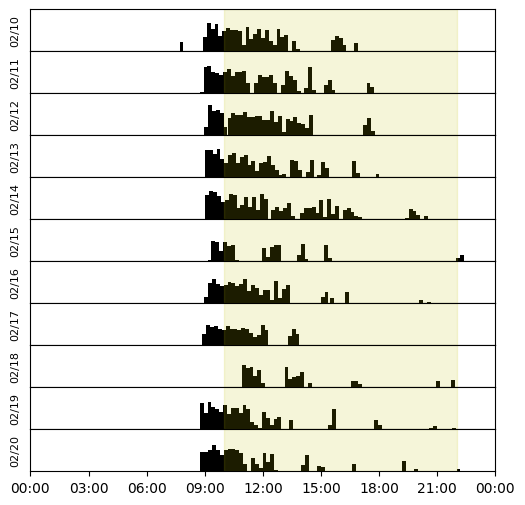

In [8]:
fig, axes = plt.subplots(figsize=(6,6), nrows=n_days)

time_form = DateFormatter('%H:%M')

for i_day in range(n_days):
    curr_day = pd.Timestamp(date_start + datetime.timedelta(days=i_day))
    next_day = pd.Timestamp(date_start + datetime.timedelta(days=i_day+1))
    wheel_detections_curr_day = df_wheel_detections[(df_wheel_detections['datetime']>=curr_day) & (df_wheel_detections['datetime']<next_day)]
    
    
    axes[i_day].bar(wheel_detections_curr_day['datetime'], wheel_detections_curr_day['counts'], width=datetime.timedelta(minutes=time_bin), color='k')
    
#     axes[i_day].bar(wheel_detections_curr_day['datetime'], 500, width=datetime.timedelta(minutes=time_bin), color='b')
    axes[i_day].add_patch(Rectangle((curr_day+time_light_on, 0), time_light_off-time_light_on, 4000, color='y', alpha=0.15))

    axes[i_day].set_xlim([curr_day, next_day])
    axes[i_day].xaxis.set_major_formatter(time_form)
    axes[i_day].set_ylim([0,4000])
    axes[i_day].set_yticks([])
    axes[i_day].set_ylabel(curr_day.strftime('%m/%d'), fontsize=8)

    if i_day < n_days-1:
        axes[i_day].set_xticks([])

plt.subplots_adjust(hspace=0)
# plt.savefig('wheel_actogram.png', dpi=300)
plt.show()

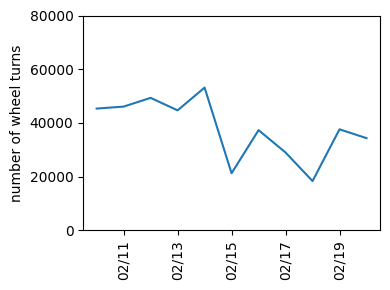

In [9]:
date_form = DateFormatter('%m/%d')
n_wheels_by_day = df_wheel_detections['counts'].groupby([df_wheel_detections['datetime'].dt.date]).sum()
days = pd.date_range(date_start, date_stop, inclusive='left')
n_wheels_by_day = n_wheels_by_day.reindex(days, fill_value=0)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(n_wheels_by_day.index, n_wheels_by_day.values)
ax.xaxis.set_major_formatter(date_form)
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlim([pd.Timestamp(date_start-datetime.timedelta(days=0.5)), pd.Timestamp(date_stop)-datetime.timedelta(days=0.5)])
ax.set_xlabel('')
ax.set_ylim([0, 80000])
ax.set_ylabel('number of wheel turns')
plt.tight_layout()
# plt.savefig('n_wheels_by_day.png', dpi=300)
plt.show()